In [60]:
import warnings
warnings.filterwarnings('ignore')

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from amplpy import AMPL, ampl_notebook

In [62]:
ampl = ampl_notebook(
    modules=['coin'],
    license_uuid='default'
)

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


In [63]:
# TEMP_PATH = r"data/"
idx = pd.IndexSlice
# df = pd.read_csv(TEMP_PATH + r"/sp500_2003_2023.csv")
df = pd.read_csv(r"sp500_2003_2023.csv")
df['date'] = pd.to_datetime(df['date'])
df  = df.set_index('date')

In [69]:
price = ['Close']
cols = df.columns
df.columns = pd.MultiIndex.from_product([cols, price], names=['Ticker','Close'])

In [85]:
df_testing = df.loc[idx[:"2014"],:]

In [115]:
ann_ret_data = df_testing.loc[['2013-01-02','2013-12-31','2014-01-02','2014-12-31'],:]
return_2013 = (ann_ret_data.iloc[1] / ann_ret_data.iloc[0]) - 1
return_2014 = (ann_ret_data.iloc[3] / ann_ret_data.iloc[2]) - 1
ann_ret = pd.concat([return_2013, return_2014], axis=1).transpose().droplevel(1, axis=1)
ann_ret['year'] = ['2013','2014']
ann_ret = ann_ret.set_index('year')

In [123]:
top50 = ann_ret.mean().sort_values(ascending=False)[:50].index


In [34]:
sample = df.loc["2013":,:].sample(20, axis=1)

In [36]:
%%ampl_eval

reset;

set ASSETS;

param returns {ASSETS};
param covariances {ASSETS, ASSETS};
param rfr >= 0, <= 1;

var f {ASSETS} >= 0;

maximize Growth:
  rfr + sum {a in ASSETS} f[a] * (returns[a] - rfr) -
  0.5 * sum {a1 in ASSETS} sum {a2 in ASSETS} f[a1] * covariances[a1, a2] * f[a2];

subject to WeightConstraint:
  sum {a in ASSETS} f[a] == 1;

In [40]:
lookback = 252
returns = sample.loc[:,idx[:,'Close']] / sample.loc[:,idx[:,'Close']].shift(1)
returns = returns.rename(columns={'Close':'returns'})
means = returns.rolling(lookback).mean().rename(columns={'returns':'means'})
var = returns.rolling(lookback).var().rename(columns={'returns':'var'})
data = pd.concat([returns, means, var], axis=1)
rfr = 0

n = returns.shape[1]
cov = returns.rolling(lookback).cov().droplevel(2, axis=0).droplevel(1, axis=1)

f = np.zeros(returns.shape)
f[:] = np.nan
g = np.zeros([returns.shape[0]])
g[:] = np.nan

In [48]:
%%capture
for i, (a, row) in enumerate(data.iterrows()):
    if i < lookback:
        continue
    returns_sub = row.loc[idx[:,'returns']]
    means_sub = row.loc[idx[:,'means']]
    var_sub = row.loc[idx[:,'var']]

    cov_sub = cov.loc[idx[means_sub.name,:],:]
    np.fill_diagonal(cov_sub.values, var_sub)

    means_dict = means_sub.to_dict()
    cov_dict = cov_sub.droplevel(0, axis=0).to_dict()
    cov_dict = {(k1, k2): v for k1 in cov_dict for k2, v in cov_dict[k1].items()}

    ampl.set['ASSETS'] = means_dict.keys()
    ampl.param['returns'] = means_dict
    ampl.param['covariances'] = cov_dict
    ampl.param['rfr'] = rfr

    ampl.option['solver'] = "ipopt"
    ampl.solve()

    g[i] = ampl.obj['Growth'].value()
    # print(list(ampl.var['f'].to_dict().values()))
    # break
    f[i] = list(ampl.var['f'].to_dict().values())

In [55]:
f_df = pd.DataFrame(f, index=returns.index, columns=returns.columns).rename(columns={'returns':'fraction'})
g_df = pd.DataFrame(g, index=returns.index)
g_df.columns = pd.MultiIndex.from_arrays([['g'],['g']])
all_df = pd.concat([sample, data, f_df, g_df], axis=1)

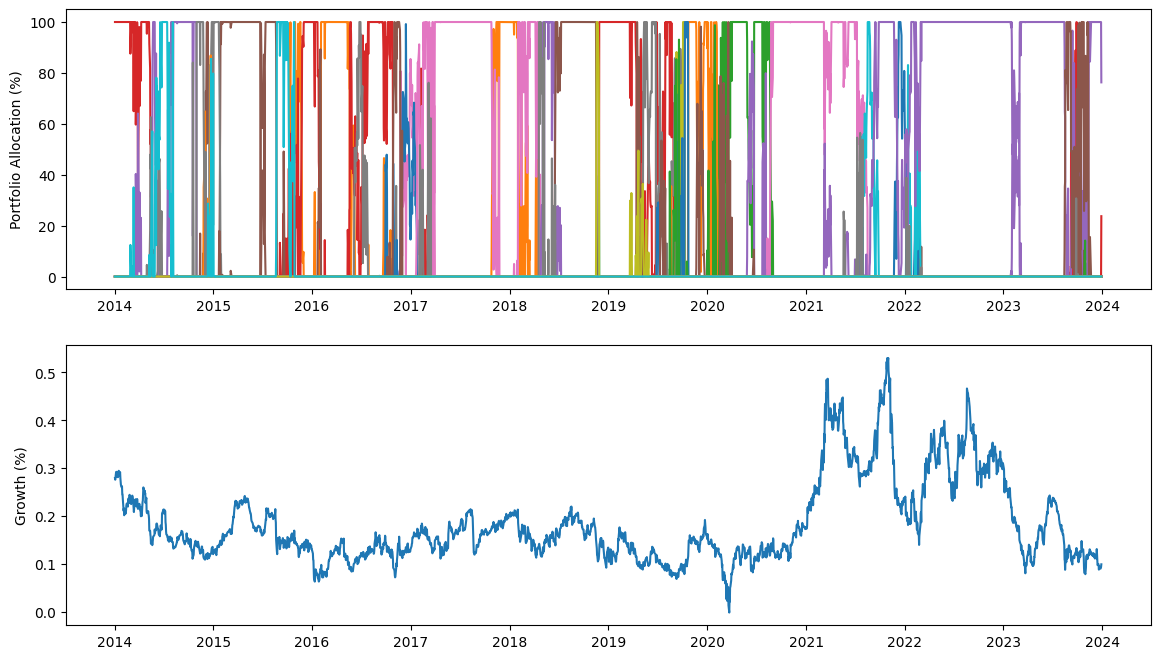

In [58]:
fig, ax = plt.subplots(2, figsize=(14,8))

ax[0].plot(all_df.loc[:,idx[:,'fraction']]*100)
ax[0].set_ylabel('Portfolio Allocation (%)')

ax[1].plot((all_df.loc[:,idx[:,'g']] - 1) * 100)
ax[1].set_ylabel('Growth (%)')
plt.show()